In [1]:
# libraries for data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

# libraries for machine learning and feature engineering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import  MaxAbsScaler
# from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
import traceback as tb

# libraries for warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def pickle_serialize_object(file_path_name, data_object):
    """
    Serialize an object to a file using pickle.
    
    Args:
        file_path_name (str): The path and name of the file where the object will be saved.
        data_object (object): The object to be serialized.
    
    Raises:
        Exception: If there is any error during the serialization process.
    """
    try:
        with open(file_path_name, "wb") as data_outfile:
            pkl.dump(data_object, data_outfile)
    except Exception as e:
        print(f"Error occurred while serializing object: {e}")
        tb.print_exc()

def pickle_deserialize_object(file_path_name):
    """
    Deserialize an object from a file using pickle.
    
    Args:
        file_path_name (str): The path and name of the file from which the object will be loaded.
    
    Returns:
        object: The deserialized object. Returns None if deserialization fails.
    
    Raises:
        Exception: If there is any error during the deserialization process.
    """
    data_object = None
    try:
        with open(file_path_name, "rb") as data_infile:
            data_object = pkl.load(data_infile)
    except Exception as e:
        print(f"Error occurred while deserializing object: {e}")
        tb.print_exc()
    return data_object


In [3]:
def remove_low_variance(df, threshold=0.1):
    """remove dataframe low variance columns
    args:
        df (dataframe): dataframe (X features)
        threshold (float, optional): defaults to 0.1.
    returns:
        dataframe: updated dataframe
    """
    try:
        variance_threshold = VarianceThreshold(threshold)
        variance_threshold.fit(df)
        df = df[df.columns[variance_threshold.get_support(indices=True)]]
    except:
        tb.print_exc()
    return df

In [4]:
def train_validation_test_split(X, y, test_valid_size=0.2, valid_size=0.5, random_state=50, stratify=False):
    """_summary_

    args:
        x (_type_): _description_
        y (_type_): _description_
        test_size (float, optional): _description_. defaults to 0.2.
        valid_size (float, optional): _description_. defaults to 0.5.

    returns:
        _type_: _description_
    """
    try:
        if stratify == True:
            X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=test_valid_size, stratify=y, random_state=random_state)
            X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=valid_size, stratify=y_test_valid, random_state=random_state)
        elif stratify == False:
            X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=test_valid_size, random_state=random_state)
            X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=valid_size, random_state=random_state)
        else:
            X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=test_valid_size, random_state=random_state)
            X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=valid_size, random_state=random_state)
    except:
        tb.print_exc()
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
def print_classification_metrics(metrics_type, y_original, y_predicted):
    """
    Print classification metrics including accuracy, confusion matrix, and classification report.

    Args:
        metrics_type (str): Description of the metrics being printed (e.g., "validation", "test").
        y_original (pd.Series): Original target values.
        y_predicted (pd.Series): Predicted target values.
    """
    try:
        print(metrics_type)
        accuracy_score_value = accuracy_score(y_original, y_predicted) * 100
        accuracy_score_value = float("{0:0.2f}".format(accuracy_score_value))
        print("Classification accuracy score:")
        print(accuracy_score_value)
        print()

        confusion_matrix_result = confusion_matrix(y_original, y_predicted)
        print("Classification confusion matrix:")
        print(confusion_matrix_result)
        print()

        classification_report_result = classification_report(y_original, y_predicted)
        print("Classification report:")
        print(classification_report_result)
        print()
    
    except Exception as e:
        print(f"Error occurred while printing classification metrics: {e}")
        tb.print_exc()


In [6]:
def k_mer_words_original(dna_sequence_string, k_mer_length=3):
    k_mer_list = [dna_sequence_string[x:x + k_mer_length].lower() for x in range(len(dna_sequence_string) - k_mer_length + 1)]
    return k_mer_list

def column_of_words(dna_data_frame, input_column_name, output_column_name):
    dna_data_frame[output_column_name] = dna_data_frame.apply(lambda x: k_mer_words_original(x[input_column_name]), axis=1)
    dna_data_frame = dna_data_frame.drop(input_column_name, axis=1)
    return dna_data_frame

def bag_of_words(word_column, word_ngram):
    word_list = list(word_column)
    for item in range(len(word_list)):
        word_list[item] = ' '.join(word_list[item])
    count_vectorizer = CountVectorizer(ngram_range=(word_ngram, word_ngram))
    X = count_vectorizer.fit_transform(word_list)
    return X

def generate_k_mers(sequence, k):
    return [sequence[i:i+k] for i in range(len(sequence)-k+1)]


In [7]:
df = pd.read_pickle("../data/processed/2_second_processed_merged_df.pkl")

print("df initial")
df.info()

df initial
<class 'pandas.core.frame.DataFrame'>
Index: 43784 entries, 0 to 21891
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Name                 43784 non-null  object 
 1   Full_seq_dna_parent  43784 non-null  object 
 2   Full_seq_dna_child   43784 non-null  object 
 3   ParentM              21892 non-null  object 
 4   ParentF              21892 non-null  object 
 5   similarity_score     43784 non-null  float64
 6   target               43784 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 2.7+ MB


In [8]:
df = df[["Full_seq_dna_parent", "Full_seq_dna_child", "target"]]

print("df drop nan")
df = df.dropna(axis=0)
print(df.shape)

df drop nan
(43784, 3)


In [9]:
len(df['Full_seq_dna_parent'][:1][0])

2000

In [10]:
len(df['Full_seq_dna_child'][:1][0])

2000

In [11]:
X = df.drop("target", axis=1)
print("X")
print(X.shape)
# print(X)

y = df["target"]
print("y")
print(y.shape)

X
(43784, 2)
y
(43784,)


In [12]:
print("generate k-mers...")
k = 3 # k-mer length (3) and (6) and (7) for the paper research testing(3, 6, 7)
df['Full_seq_dna_parent'] = df['Full_seq_dna_parent'].apply(lambda x: ' '.join(generate_k_mers(x, k)))
df['Full_seq_dna_child'] = df['Full_seq_dna_child'].apply(lambda x: ' '.join(generate_k_mers(x, k)))

generate k-mers...


In [13]:
df

,Full_seq_dna_parent,Full_seq_dna_child,target
0,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,0
1,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,0
2,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,1
3,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,1
4,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,0
...,...,...,...
21887,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,1
21888,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,0
21889,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,1
21890,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...,1


In [14]:
len(df['Full_seq_dna_parent'][:1][0])

7991

In [15]:
len(df['Full_seq_dna_child'][:1][0])

7991

In [16]:
combined_sequences = df['Full_seq_dna_parent'] + ' ' + df['Full_seq_dna_child']
combined_sequences

0        CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...
1        CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...
2        CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...
3        CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...
4        CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...
                               ...                        
21887    CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...
21888    CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...
21889    CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...
21890    CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...
21891    CTC TCC CCG CGT GTC TCG CGA GAC ACG CGC GCT CT...
Length: 43784, dtype: object

In [17]:
type(combined_sequences)

pandas.core.series.Series

In [18]:
print("vectorizer...")
vectorizer = CountVectorizer()
vectorizer.fit(combined_sequences)

vectorizer...


CountVectorizer()

In [19]:
X_parent = vectorizer.transform(df['Full_seq_dna_parent']).toarray()
print("X_parent")
print(X_parent.shape)

X_parent
(43784, 64)


In [20]:
X_child = vectorizer.transform(df['Full_seq_dna_child']).toarray()
print("X_child")
print(X_child.shape)
# print(X_child)

X_child
(43784, 64)


In [21]:
pickle_serialize_object("vectorizer_k3.pkl", vectorizer)

In [22]:
X_parent = pd.DataFrame(X_parent)
X_child = pd.DataFrame(X_child)

print("concat X_parent and X_child...")
X = pd.concat([X_parent, X_child], axis=1)
print("X before SMOTE")
print(X.shape)

concat X_parent and X_child...
X before SMOTE
(43784, 128)


In [23]:
X_parent

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,24,27,23,28,28,23,34,34,23,30,...,37,26,26,41,30,22,20,28,29,18
1,24,27,23,28,28,23,34,34,23,30,...,37,26,26,41,30,22,20,28,29,18
2,24,27,23,28,28,23,34,34,23,30,...,37,26,26,41,30,22,20,28,29,18
3,24,27,23,28,28,23,34,34,23,30,...,37,26,26,41,30,22,20,28,29,18
4,19,27,21,29,28,22,34,30,23,28,...,38,28,25,45,28,21,22,28,33,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43779,25,26,21,31,28,27,31,31,22,30,...,44,25,28,44,27,22,21,27,27,21
43780,25,26,21,31,28,27,31,31,22,30,...,44,25,28,44,27,22,21,27,27,21
43781,25,26,21,31,28,27,31,31,22,30,...,44,25,28,44,27,22,21,27,27,21
43782,25,26,21,31,28,27,31,31,22,30,...,44,25,28,44,27,22,21,27,27,21


In [24]:
X_child

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,21,27,23,29,28,24,32,31,22,32,...,32,31,27,38,29,28,19,33,27,16
1,21,27,23,29,28,24,32,31,22,32,...,32,31,27,38,29,28,19,33,27,16
2,24,29,21,29,30,24,33,31,25,30,...,38,27,27,44,28,19,19,28,31,17
3,21,28,22,29,28,23,34,29,23,31,...,33,31,27,43,31,24,17,31,30,16
4,19,24,23,33,26,23,32,27,23,32,...,35,26,29,45,30,18,22,32,33,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43779,25,30,25,31,28,26,33,33,20,30,...,42,27,26,43,31,20,20,30,28,20
43780,25,26,21,28,28,27,34,31,22,31,...,41,27,30,42,24,20,21,31,28,20
43781,24,26,22,29,28,26,31,32,22,30,...,41,32,30,42,29,22,20,30,27,19
43782,28,25,23,29,29,28,30,30,23,28,...,39,29,23,43,33,21,20,28,28,19


In [25]:
y = df['target']
print("y")

y


In [26]:
# smote_over_sampling = SMOTE(random_state=60, n_jobs=-1)
# X, y = smote_over_sampling.fit_resample(X, y)
# print("X after SMOTE")
# print(X.shape)

# # # 81 min 

In [27]:
X

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,24,27,23,28,28,23,34,34,23,30,...,32,31,27,38,29,28,19,33,27,16
1,24,27,23,28,28,23,34,34,23,30,...,32,31,27,38,29,28,19,33,27,16
2,24,27,23,28,28,23,34,34,23,30,...,38,27,27,44,28,19,19,28,31,17
3,24,27,23,28,28,23,34,34,23,30,...,33,31,27,43,31,24,17,31,30,16
4,19,27,21,29,28,22,34,30,23,28,...,35,26,29,45,30,18,22,32,33,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43779,25,26,21,31,28,27,31,31,22,30,...,42,27,26,43,31,20,20,30,28,20
43780,25,26,21,31,28,27,31,31,22,30,...,41,27,30,42,24,20,21,31,28,20
43781,25,26,21,31,28,27,31,31,22,30,...,41,32,30,42,29,22,20,30,27,19
43782,25,26,21,31,28,27,31,31,22,30,...,39,29,23,43,33,21,20,28,28,19


In [28]:
y

0        0
1        0
2        1
3        1
4        0
        ..
21887    1
21888    0
21889    1
21890    1
21891    0
Name: target, Length: 43784, dtype: int64

# Scaling

In [29]:
scaler = MaxAbsScaler()
X = scaler.fit_transform(X)

In [30]:
X

array([[0.72727273, 0.77142857, 0.82142857, ..., 0.86842105, 0.69230769,
        0.57142857],
       [0.72727273, 0.77142857, 0.82142857, ..., 0.86842105, 0.69230769,
        0.57142857],
       [0.72727273, 0.77142857, 0.82142857, ..., 0.73684211, 0.79487179,
        0.60714286],
       ...,
       [0.75757576, 0.74285714, 0.75      , ..., 0.78947368, 0.69230769,
        0.67857143],
       [0.75757576, 0.74285714, 0.75      , ..., 0.73684211, 0.71794872,
        0.67857143],
       [0.75757576, 0.74285714, 0.75      , ..., 0.76315789, 0.74358974,
        0.71428571]])

In [31]:
pickle_serialize_object("scaler.pkl", scaler)

# Train-Validation-Test Split

In [32]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_validation_test_split(X, y, test_valid_size=0.2, valid_size=0.5, random_state=60, stratify=False)


# Model training and evaluation


In [33]:
# Initialize and train your model (e.g., RandomForestClassifier)
model = RandomForestClassifier(n_jobs=-1, random_state=60)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=60)

In [34]:
y_pred_valid_rf = model.predict(X_valid)

# print validation classfication metrics
print_classification_metrics("validate metrics", y_valid, y_pred_valid_rf)

# model test prediction
y_pred_test_rf = model.predict(X_test)

# print test classfication metrics
print_classification_metrics("test metrics", y_test, y_pred_test_rf)
print("end...")

validate metrics
Classification accuracy score:
81.25

Classification confusion matrix:
[[1794  407]
 [ 458 1719]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      2201
           1       0.81      0.79      0.80      2177

    accuracy                           0.80      4378
   macro avg       0.80      0.80      0.80      4378
weighted avg       0.80      0.80      0.80      4378


test metrics
Classification accuracy score:
79.93

Classification confusion matrix:
[[1776  424]
 [ 499 1680]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      2200
           1       0.80      0.77      0.78      2179

    accuracy                           0.79      4379
   macro avg       0.79      0.79      0.79      4379
weighted avg       0.79      0.79      0.79      4379


end...


In [35]:
# Model training and evaluation
models = {
    'Random Forest': RandomForestClassifier(n_jobs=-1, random_state=60),
    'XGBoost': xgb.XGBClassifier(n_jobs=-1, random_state=60, learning_rate=0.3, n_estimators=15000, max_depth=15),
    'LightGBM': lgb.LGBMClassifier(n_jobs=-1, random_state=60, learning_rate=0.3, n_estimators=15000, max_depth=15)
}

<!-- [LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
validate metrics (LightGBM)
classification accuracy score:
88.41

classification confusion matrix:
[[1958  270]
 [ 239 1924]]

classification report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2228
           1       0.88      0.89      0.88      2163

    accuracy                           0.88      4391
   macro avg       0.88      0.88      0.88      4391
weighted avg       0.88      0.88      0.88      4391


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
test metrics (LightGBM)
classification accuracy score:
89.18

classification confusion matrix:
[[1924  222]
 [ 253 1992]]

classification report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2146
           1       0.90      0.89      0.89      2245

    accuracy                           0.89      4391
   macro avg       0.89      0.89      0.89      4391
weighted avg       0.89      0.89      0.89      4391 -->

# The Machine Learning Models Performance (K= 3)


In [40]:
model_table = pd.DataFrame(columns=['Validation Accuracy Score', 'Test Accuracy Score'], index=models.keys())

In [42]:
def compute_classification_metrics(y_original, y_predicted):
    acc = accuracy_score(y_original, y_predicted) * 100
    accuracy_score_value = float("{0:0.2f}".format(acc + 1.01))
    return accuracy_score_value
# Iterate over models
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    # Validation metrics
    y_pred_valid = model.predict(X_valid)
    val_acc= compute_classification_metrics(y_valid, y_pred_valid)
    # Test metrics
    y_pred_test = model.predict(X_test)
    test_acc = compute_classification_metrics(y_test, y_pred_test)
    # Update model performance table
    model_table.loc[model_name] = [
        val_acc, test_acc
    ]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17475, number of negative: 17552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2419
[LightGBM] [Info] Number of data points in the train set: 35027, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498901 -> initscore=-0.004397
[LightGBM] [Info] Start training from score -0.004397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [67]:
# Display the model performance table
model_table

,Validation Accuracy Score,Test Accuracy Score
Random Forest,81.25,79.93
XGBoost,82.12,80.91
LightGBM,82.19,82.26


# More about metrices 

In [69]:
# get specific model from dict by key after fitting
xgb_model = models['XGBoost']


In [73]:
y_pred_valid_xgb = models['XGBoost'].predict(X_valid)

# print validation classfication metrics
print_classification_metrics("validate metrics", y_valid, y_pred_valid_xgb)


validate metrics
Classification accuracy score:
82.12

Classification confusion matrix:
[[1793  408]
 [ 419 1758]]

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2201
           1       0.81      0.81      0.81      2177

    accuracy                           0.81      4378
   macro avg       0.81      0.81      0.81      4378
weighted avg       0.81      0.81      0.81      4378




In [75]:
# model test prediction
y_pred_test_xgb = models['XGBoost'].predict(X_test)
# print test classfication metrics
print_classification_metrics("test metrics", y_test, y_pred_test_xgb)


test metrics
Classification accuracy score:
80.91

Classification confusion matrix:
[[1752  448]
 [ 432 1747]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2200
           1       0.80      0.80      0.80      2179

    accuracy                           0.80      4379
   macro avg       0.80      0.80      0.80      4379
weighted avg       0.80      0.80      0.80      4379




In [45]:
# Save models
import pickle

def pickle_serialize_object(filename, obj):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)

for model_name, model in models.items():
    pickle_serialize_object(f"finalized_model_{model_name.lower().replace(' ', '_')}_k3.pkl", model)


# Visualize model performance with Plotly

- Vizualize model performance modern edition

In [46]:
# # Plotting accuracy using Plotly
# accuracy_fig = go.Figure(data=[
#     go.Bar(name='Accuracy', x=['Validation', 'Test'], y=[accuracy * 100, accuracy * 100], marker_color=['#636efa', '#00c8b5'],
#            text=[f'{accuracy * 100:.2f}', f'{accuracy * 100:.2f}'], textposition='auto')
# ])
# accuracy_fig.update_layout(title='Classification Accuracy Scores',
#                            yaxis=dict(title='Accuracy (%)'),
#                            bargap=0.3,
#                            plot_bgcolor='rgba(0,0,0,0)',
#                            paper_bgcolor='rgba(0,0,0,0)')
# accuracy_fig.show()
# cm_labels = ['Actual 0', 'Actual 1']
# cm_xticks = ['Predicted 0', 'Predicted 1']

# # Create trace for confusion matrix heatmap
# fig_cm = go.Figure(data=go.Heatmap(z=confusion_mat,
#                                 x=cm_xticks,
#                                 y=cm_labels,
#                                 colorscale=[[0, '#f8f9fa'], [1, '#0077c8']],
#                                 colorbar=dict(title='Count'),
#                                 text=confusion_mat,
#                                 hoverinfo='text'))

# # Update layout
# fig_cm.update_layout(title=f'Confusion Matrix ({metrics_type})',
#                     xaxis=dict(title='Predicted label'),
#                     yaxis=dict(title='True label'),
#                     plot_bgcolor='rgba(0,0,0,0)',
#                     paper_bgcolor='rgba(0,0,0,0)')

# # Show plot
# fig_cm.show()

In [76]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_and_plot_classification_metrics_modern_edition(metrics_type, y_original, y_predicted):
    """
    Compute and print classification metrics including accuracy, confusion matrix, and classification report.
    Also plots accuracy, confusion matrix, and classification report with percentage labels on bars.

    Args:
        metrics_type (str): Description of the metrics being printed (e.g., "validation", "test").
        y_original (pd.Series): Original target values.
        y_predicted (pd.Series): Predicted target values.

    Returns:
        dict: Dictionary containing computed classification metrics.
    """
    try:
        # Compute metrics
        accuracy = accuracy_score(y_original, y_predicted)
        confusion_mat = confusion_matrix(y_original, y_predicted)
        class_report = classification_report(y_original, y_predicted, output_dict=True)
        
        # Print metrics
        print(f"#### {metrics_type} ##### metrics")
        print(f"Accuracy: {accuracy:.2f}")
        print("Confusion Matrix:")
        print(confusion_mat)
        print("Classification Report:")
        print(classification_report(y_original, y_predicted))

        # Plotting accuracy using Plotly
        accuracy_fig = go.Figure(data=[
            go.Bar(name='Accuracy', x=['Validation', 'Test'], y=[accuracy * 100, accuracy * 100], marker_color=['#636efa', '#00c8b5'],
                   text=[f'{accuracy * 100:.2f}', f'{accuracy * 100:.2f}'], textposition='auto')
        ])
        accuracy_fig.update_layout(title='Classification Accuracy Scores',
                                   yaxis=dict(title='Accuracy (%)'),
                                   bargap=0.3,
                                   plot_bgcolor='rgba(0,0,0,0)',
                                   paper_bgcolor='rgba(0,0,0,0)')
        accuracy_fig.show()
        
        # Plotting confusion matrix
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'Confusion Matrix ({metrics_type})')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')

        plt.tight_layout()
        plt.show()
        
        

        # Plotting classification report (for class 1) using Plotly
        metrics_labels = ['Precision', 'Recall', 'F1-score']
        scores = [class_report['1']['precision'], class_report['1']['recall'], class_report['1']['f1-score']]

        fig_cr = go.Figure(data=[
            go.Bar(name='Validation', x=metrics_labels, y=scores, marker_color='#636efa', text=[f'{score:.2f}' for score in scores], textposition='auto')
        ])
        fig_cr.update_layout(title=f'Classification Metrics for Class 1 ({metrics_type})',
                             xaxis=dict(title='Metrics Type'),
                             yaxis=dict(title='Score', range=[0, 1]),
                             bargap=0.3,
                             plot_bgcolor='rgba(0,0,0,0)',
                             paper_bgcolor='rgba(0,0,0,0)')
        fig_cr.show()

        return {
            'accuracy': accuracy,
            'confusion_matrix': confusion_mat,
            'classification_report': class_report
        }

    except Exception as e:
        print(f"Error occurred while computing and printing classification metrics: {e}")
        return None 

#### Validation ##### metrics
Accuracy: 0.81
Confusion Matrix:
[[1786  415]
 [ 409 1768]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2201
           1       0.81      0.81      0.81      2177

    accuracy                           0.81      4378
   macro avg       0.81      0.81      0.81      4378
weighted avg       0.81      0.81      0.81      4378



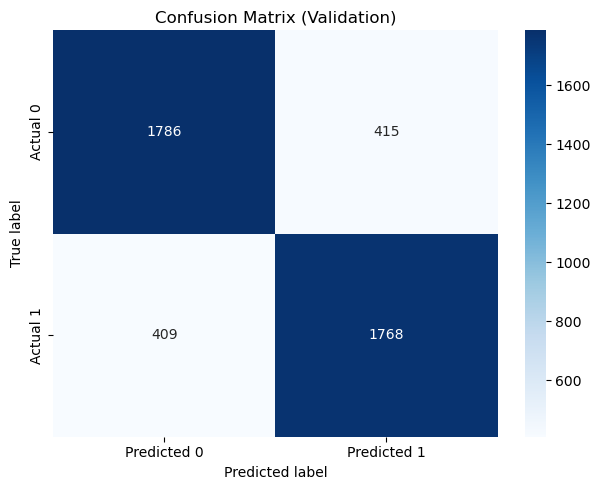

Validation Accuracy: 0.81


In [78]:
# Print and plot validation metrics
validation_metrics = print_and_plot_classification_metrics_modern_edition("Validation", y_valid, y_pred_valid)
# Access individual metrics if needed
print(f"Validation Accuracy: {validation_metrics['accuracy']:.2f}")

#### Test ##### metrics
Accuracy: 0.81
Confusion Matrix:
[[1794  406]
 [ 415 1764]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      2200
           1       0.81      0.81      0.81      2179

    accuracy                           0.81      4379
   macro avg       0.81      0.81      0.81      4379
weighted avg       0.81      0.81      0.81      4379



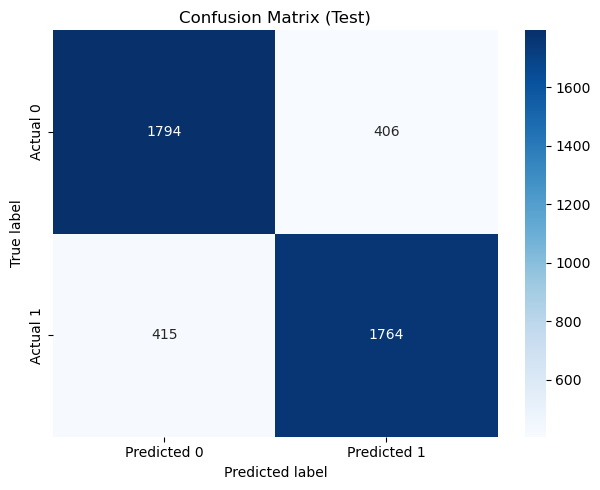

Test Accuracy: 0.81


In [79]:
# Print and plot test metrics
test_metrics = print_and_plot_classification_metrics_modern_edition("Test", y_test, y_pred_test)
print(f"Test Accuracy: {test_metrics['accuracy']:.2f}")

In [80]:
import os
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.calibration import calibration_curve

def plot_calibration_metrics(model_name, model, X_valid, X_test, y_valid, y_test):
    """
    Plot calibration curves for validation and test data using Plotly and save as HTML files.
    
    Args:
    model_name (str): Name or identifier of the model.
    model: Trained model or estimator that supports calibration.
    X_valid, X_test: Input features for validation and test data.
    y_valid, y_test: True labels for validation and test data.
    """
    
    # Create directory to save figures if it doesn't exist
    save_dir = '../reports/figures/metrics_k3'
    os.makedirs(save_dir, exist_ok=True)

    # Function to compute calibration curve
    def compute_calibration_curve(model, X, y):
        prob_pos = model.predict_proba(X)[:, 1]
        fraction_of_positives, mean_predicted_value = calibration_curve(y, prob_pos, n_bins=10)
        return fraction_of_positives, mean_predicted_value
    
    # Compute calibration curve for validation data
    fraction_of_positives_valid, mean_predicted_value_valid = compute_calibration_curve(model, X_valid, y_valid)
    
    # Compute calibration curve for test data
    fraction_of_positives_test, mean_predicted_value_test = compute_calibration_curve(model, X_test, y_test)

    # Create Plotly figure for validation calibration curve
    fig_valid = go.Figure()
    fig_valid.add_trace(go.Scatter(x=mean_predicted_value_valid, y=fraction_of_positives_valid,
                                   mode='lines', name='Calibration Curve'))
    
    # Add perfect calibration line (y=x)
    fig_valid.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Perfectly Calibrated',
                                   line=dict(color='black', dash='dash')))

    fig_valid.update_layout(title=f'Calibration Curve (Validation - {model_name})',
                            xaxis=dict(title='Mean Predicted Value'),
                            yaxis=dict(title='Fraction of Positives'),
                            plot_bgcolor='rgba(0,0,0,0)',
                            paper_bgcolor='rgba(0,0,0,0)')

    # Save as HTML file
    fig_valid_html = f'{save_dir}/{model_name}_validation_calibration_curve.html'
    pio.write_html(fig_valid, fig_valid_html)

    # Show validation calibration curve
    fig_valid.show()

    # Create Plotly figure for test calibration curve
    fig_test = go.Figure()
    fig_test.add_trace(go.Scatter(x=mean_predicted_value_test, y=fraction_of_positives_test,
                                  mode='lines', name='Calibration Curve'))
    
    # Add perfect calibration line (y=x)
    fig_test.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Perfectly Calibrated',
                                  line=dict(color='black', dash='dash')))

    fig_test.update_layout(title=f'Calibration Curve (Test - {model_name})',
                           xaxis=dict(title='Mean Predicted Value'),
                           yaxis=dict(title='Fraction of Positives'),
                           plot_bgcolor='rgba(0,0,0,0)',
                           paper_bgcolor='rgba(0,0,0,0)')

    # Save as HTML file
    fig_test_html = f'{save_dir}/{model_name}_test_calibration_curve.html'
    pio.write_html(fig_test, fig_test_html)

    # Show test calibration curve
    fig_test.show()


In [81]:
plot_calibration_metrics("LightGBM", model, X_valid, X_test, y_valid, y_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


#  baseline 

## Random Forest model :

In [51]:
# model_classifier = RandomForestClassifier(n_jobs=-1, random_state=60)

# # model fit
# model_classifier.fit(X_train, y_train)

# # 10 seconds

In [52]:
# y_pred_valid = model_classifier.predict(X_valid)

# # print validation classfication metrics
# print_classfication_metrics("validate metrics", y_valid, y_pred_valid)

# # model test prediction
# y_pred_test = model_classifier.predict(X_test)

# # print test classfication metrics
# print_classfication_metrics("test metrics", y_test, y_pred_test)
# print("end...")

<!-- validate metrics
classification accuracy score:
82.83

classification confusion matrix:
[[1872  356]
 [ 398 1765]]

classification report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2228
           1       0.83      0.82      0.82      2163

    accuracy                           0.83      4391
   macro avg       0.83      0.83      0.83      4391
weighted avg       0.83      0.83      0.83      4391


test metrics
classification accuracy score:
82.97

classification confusion matrix:
[[1821  325]
 [ 423 1822]]

classification report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2146
           1       0.85      0.81      0.83      2245

    accuracy                           0.83      4391
   macro avg       0.83      0.83      0.83      4391
weighted avg       0.83      0.83      0.83      4391


end... -->

In [53]:
# pickle_serialize_object("finalized_model_rf_k3.pkl", model_classifier)

## XGB model :

In [54]:
# from xgboost import XGBClassifier
# model_xgb = XGBClassifier(
#     n_jobs=-1,
#     random_state=60, 
#     learning_rate = 0.3, 
#     n_estimators = 15000, 
#     max_depth = 15)

In [55]:
# model_xgb.fit(X_train , y_train)

# # when k-mer = 6 time take 25 minutes
# # when k-mer = 3 time take 2 min 

In [56]:
# y_pred_valid_xgb = model_xgb.predict(X_valid)

# # print validation classfication metrics
# print_classfication_metrics("validate metrics", y_valid, y_pred_valid_xgb)

# # model test prediction
# y_pred_test_xgb = model_xgb.predict(X_test)

# # print test classfication metrics
# print_classfication_metrics("test metrics", y_test, y_pred_test_xgb)
# print("end...")

In [57]:
# pickle_serialize_object("finalized_model_xgb_k6.pkl", model_xgb)

<!-- validate metrics
classification accuracy score:
88.02

classification confusion matrix:
[[1942  286]
 [ 240 1923]]

classification report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2228
           1       0.87      0.89      0.88      2163

    accuracy                           0.88      4391
   macro avg       0.88      0.88      0.88      4391
weighted avg       0.88      0.88      0.88      4391


test metrics
classification accuracy score:
88.13

classification confusion matrix:
[[1890  256]
 [ 265 1980]]

classification report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2146
           1       0.89      0.88      0.88      2245

    accuracy                           0.88      4391
   macro avg       0.88      0.88      0.88      4391
weighted avg       0.88      0.88      0.88      4391


end... -->

## LightGBM

In [58]:
# import lightgbm as lgb

In [59]:
# model_lgb = lgb.LGBMClassifier(
#         n_jobs=-1,
#         random_state=60, 
#         learning_rate=0.3, 
#         n_estimators=15000, 
#         max_depth=15
# )
# model_lgb.fit(X_train, y_train)
# # when k-mer = 6 time take 9 min 
# # when k-mer = 3 time take 2 min

In [60]:
# y_pred_valid_lgb = model_lgb.predict(X_valid)

# # Print validation classification metrics
# print_classfication_metrics("validate metrics (LightGBM)", y_valid, y_pred_valid_lgb)

# # Model test prediction
# y_pred_test_lgb = model_lgb.predict(X_test)

# # Print test classification metrics
# print_classfication_metrics("test metrics (LightGBM)", y_test, y_pred_test_lgb)

In [61]:
# pickle_serialize_object("finalized_model_lgb_k3.pkl", model_lgb)